# Differentiable programming for particle physics simulations

In this workshop we will explore the challenges and opportunities that arise in integrating automatic differentiation (AD) platforms with simulations in particle physics. 

It is well known that the main drivers of success behind deep learning were the powerful AD engines such as TensorFlow and PyTorch. Since then, those technologies grew up into full-fledged differentiable programming (DP) frameworks capable of tackling a more diversified set of tasks. 

Recently, a very fruitful interaction between DP, as we know it in machine learning, and numerical solutions to differential equations started to gather pace. On one hand, we obtain a more flexible and data-driven approach to mathematical modelling that opens the door to solving applied problems that we couldn't tackle before. On the other hand, many techniques such that the adjoint sensitivity methods gave rise to whole new powerful algorithms for AD.

In particle physics simulations, we have a similar picture which is almost unexplored so far. The dynamics are richer than the ones considered before, but we also have more tools at our disposal, such as the backward Monte-Carlo techniques for example. We will give an overview of the theoretical background behind those ideas and provide code examples (in python and C++) of the relevant computational tools that are available to us in PyTorch's AutoGrad/ATen libraries.

In [1]:
import torch
import torch.autograd
import torch.autograd.functional
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

In [3]:
x = torch.linspace(-5., 5., 500)
knode = torch.tensor([0.,5., 10.])
detector =  torch.zeros(2)
material_A = 0.01
material_B = 0.9
thetas = torch.tensor([0.1,0.0, -0.08]) * np.pi

In [4]:
def level_set(t, node, x, sigma=10.):
    zz02 = (-sigma * torch.log(t)) - (x - node[0]).pow(2)
    zz0 =  torch.sqrt(zz02[zz02 > 0])
    xs = x[zz02 > 0]
    zs = node[1] - zz0
    return xs, zs

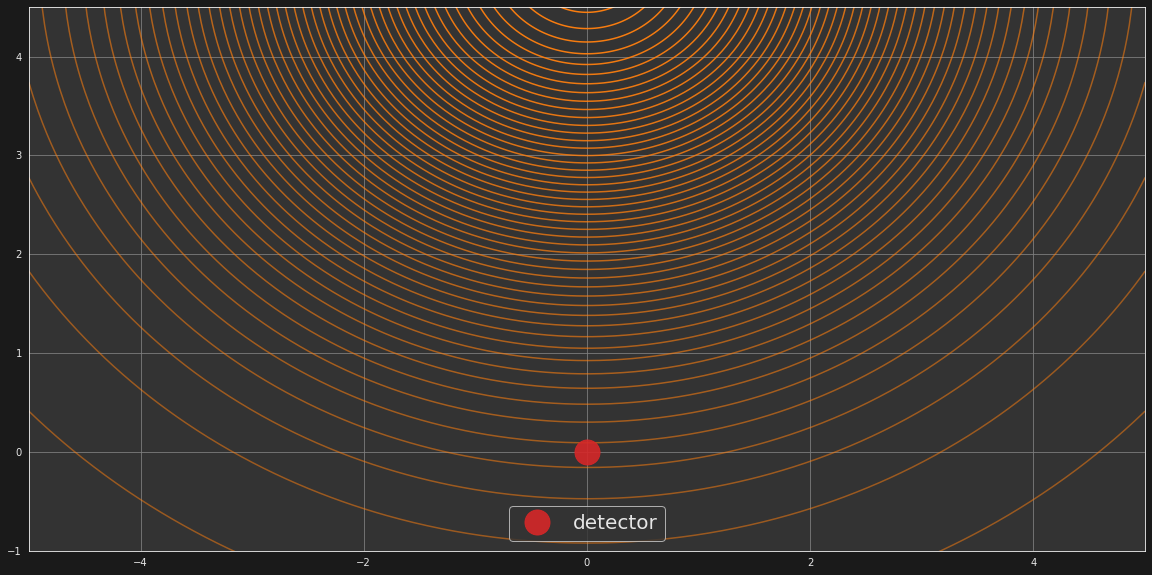

In [5]:
def plot_detector(node_param):
    plt.figure(figsize=(20,10))

    for t in torch.linspace(0.01,0.99, 50):
        xs, zs = level_set(t, node_param, x)
        plt.plot(xs.numpy(), zs.numpy(), 'C1',alpha=.5 + 0.5*t.item())

    plt.plot(detector[0].numpy(), detector[1].numpy(), '.C3',markersize=50, label='detector',alpha=0.9)
    
    plt.legend(fontsize=20)
    plt.xlim([-5.,5.]) 
    plt.ylim([-1.,4.5])
plot_detector(knode)

In [6]:
def mix_density(state, node):
    return torch.exp(-(state - node[:2]).pow(2).sum(1) / node[2])

In [8]:
def rot(theta):
    n = theta.numel()
    c = torch.cos(theta)
    s = torch.sin(theta)
    return torch.stack([c,-s, s, c]).T.reshape((n,2,2))

In [9]:
def backward_mc(theta, node, npar):
    length1 =  1.0 - 0.2 * torch.rand(npar)
    rot1 = rot(theta)
    step1 = torch.stack([torch.zeros(npar),  length1]).T
    step1 = rot1.matmul(step1.reshape((npar, 2,1))).squeeze()
    state1 = detector + step1

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state1, node)
    weights = torch.where(biasing > 0, density * material_A, (1 - density) * material_B) / (length1 * 0.5)
    
    length2 =  1.0 - 0.2 * torch.rand(npar)
    rot2 = rot(0.05 * np.pi * (torch.rand(npar) - 0.5))
    step2 = length2.reshape((npar,1)) * step1 / length1.reshape((npar,1))
    step2 = rot2.matmul(step2.reshape((npar,2,1))).squeeze()
    state2 = state1 + step2

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state2, node)
    weights *= torch.where(biasing > 0, density * material_A, (1 - density) * material_B) / (length1 * 0.5)
    
    return weights, [state1, state2]

In [13]:
bmcs = []
for theta in thetas:
    _, bmc = backward_mc(theta, knode, 10)
    bmcs.append(torch.stack(bmc).transpose(0,1))

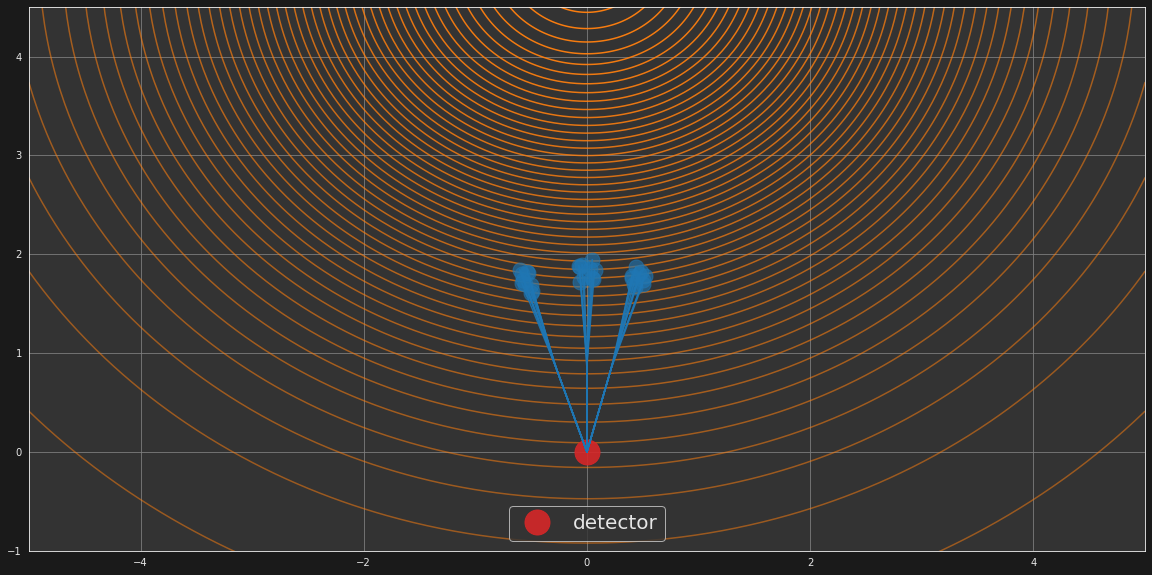

In [14]:
def plot_particles(bmc):
    for particle in bmc:
        plt.plot(particle[-1][0].numpy(), particle[-1][1].numpy(), '.C0',markersize=30, alpha=0.6)
        trajectory = torch.cat([detector.reshape(1,2), particle]).T
        plt.plot(trajectory[0].numpy(),trajectory[1].numpy(), 'C0', alpha=0.9) 
        
def plot_bmc(bmc_data, node_param):
    plot_detector(node_param)
    for bmc in bmc_data:
        plot_particles(bmc)

plot_bmc(bmcs, knode)

In [15]:
for theta in thetas:
    print(f'Flux at {round(theta.item(),2)}: {backward_mc(theta, knode, 100000)[0].mean()}')

Flux at 0.31: 0.564327597618103
Flux at 0.0: 0.538191020488739
Flux at -0.25: 0.5587713122367859


In [16]:
observed_flux = torch.tensor([0.54, 0.57, 0.62])

In [17]:
def log_prob_flux(node_params):
    log_prob = torch.tensor(0.)
    for i in range(len(thetas)):
        log_prob += (observed_flux[i] - backward_mc(thetas[i], node_params, 100000)[0].mean()).pow(2) / 0.01
    return - log_prob

In [18]:
knodeg = knode.clone().requires_grad_()
pflux = - log_prob_flux(knodeg)
dpflux = torch.autograd.grad(outputs=pflux, inputs=knodeg)[0]
dpflux[0]

tensor(0.6075)

In [19]:
knodeg = knode.clone()
hess = torch.autograd.functional.hessian(log_prob_flux, knodeg)
hess

tensor([[ 6.7975e-01, -3.9518e-02,  7.0189e-02],
        [-3.9518e-02, -4.8560e+01,  8.5420e+00],
        [ 7.0189e-02,  8.5420e+00, -1.4688e+00]])

In [20]:
def eval_gradient(node_params):
    nodeg = node_params.detach().requires_grad_()
    pflux = - log_prob_flux(nodeg)
    dpflux = torch.autograd.grad(outputs=pflux, inputs=nodeg)[0]
    return dpflux

In [21]:
nu = 0.05
N = 501
gdescent = torch.zeros(N) 

In [22]:
inode = torch.tensor([5.,15.,10.]) 
new_knode = inode - nu * eval_gradient(inode)  
res = []
for i in range(N):
    g = eval_gradient(new_knode)
    new_knode -= nu * g / (g.norm() + 1e-6)
    gdescent[i] = - log_prob_flux(new_knode)
    if i % 50 == 0:
        print(f'log probability : {gdescent[i]}')
        print(f'node {i} : {new_knode}')
    if i > (N-100):
        res.append(new_knode.detach().clone())

log probability : 57.972618103027344
node 0 : tensor([ 4.9906, 14.9746, 10.0192])
log probability : 55.158447265625
node 50 : tensor([ 4.3006, 13.1070, 11.2582])
log probability : 56.972469329833984
node 100 : tensor([ 3.5164, 10.9901, 12.3286])
log probability : 52.478431701660156
node 150 : tensor([ 2.6962,  8.7797, 13.1569])
log probability : 15.201504707336426
node 200 : tensor([ 1.8468,  6.5069, 13.7559])
log probability : 0.541497528553009
node 250 : tensor([ 0.4377,  5.7621, 13.9997])
log probability : 0.1565788835287094
node 300 : tensor([-0.7628,  5.7298, 14.0066])
log probability : 0.05605064705014229
node 350 : tensor([-1.3400,  5.5930, 13.9903])
log probability : 0.024721654132008553
node 400 : tensor([-1.6269,  5.4887, 13.9781])
log probability : 0.02060474269092083
node 450 : tensor([-1.7723,  5.4278, 13.9714])
log probability : 0.019165832549333572
node 500 : tensor([-1.8506,  5.3924, 13.9681])


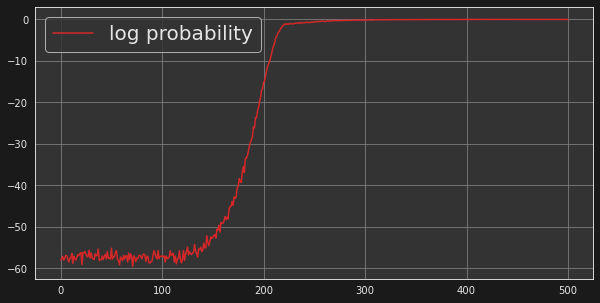

In [23]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(N), -gdescent.numpy(), 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

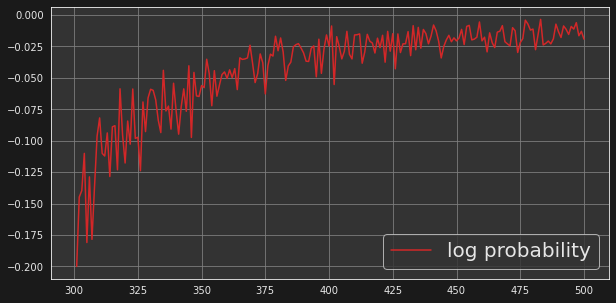

In [24]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(N)[-200:], -gdescent.numpy()[-200:], 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

In [25]:
optimal_node = torch.stack(res[-50:]).mean(0)
optimal_node

tensor([-1.8058,  5.3855, 13.9734])

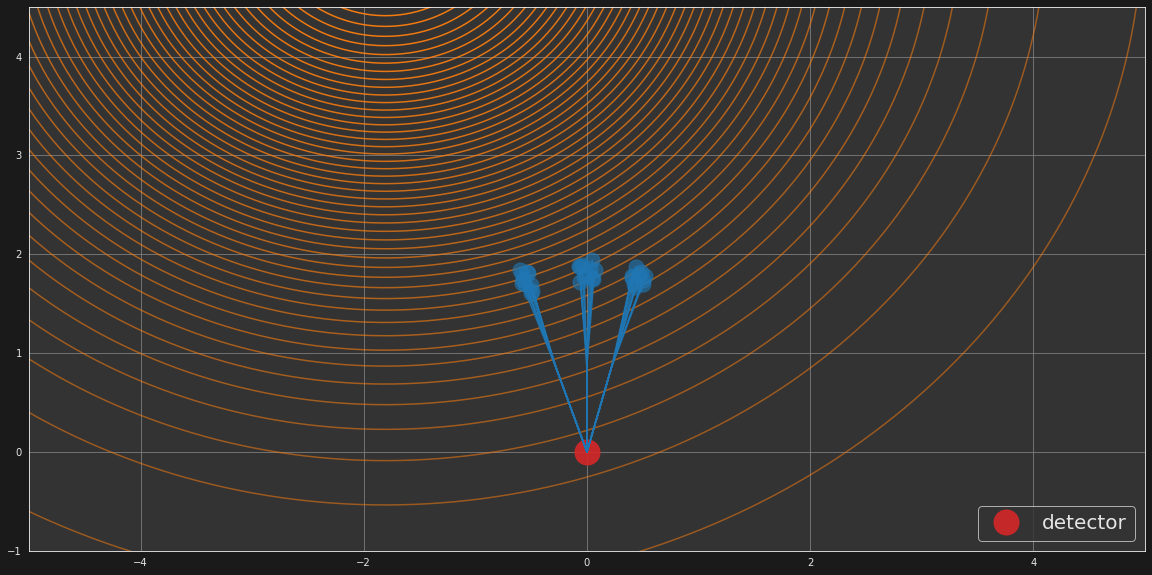

In [26]:
plot_bmc(bmcs, optimal_node)